In [1]:
import os
import copy
import pickle
import warnings
import math
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
from matplotlib.patches import Ellipse,Annulus,Arc,PathPatch

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import palettable
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture,EllipticalAnnulus

from astropy.utils.console import ProgressBar
from astropy.table import QTable
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 40})

In [2]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"

In [13]:
with open(data_dir+"galaxies_tng300_072_map_data_154.txt",'rb') as f: 
    map_dict1=pickle.load(f)
with open(data_dir+"galaxies_tng300_072_map_data_115.txt",'rb') as f: 
    map_dict2=pickle.load(f)

In [14]:
cmap0=palettable.cmocean.sequential.Dense_6.mpl_colormap

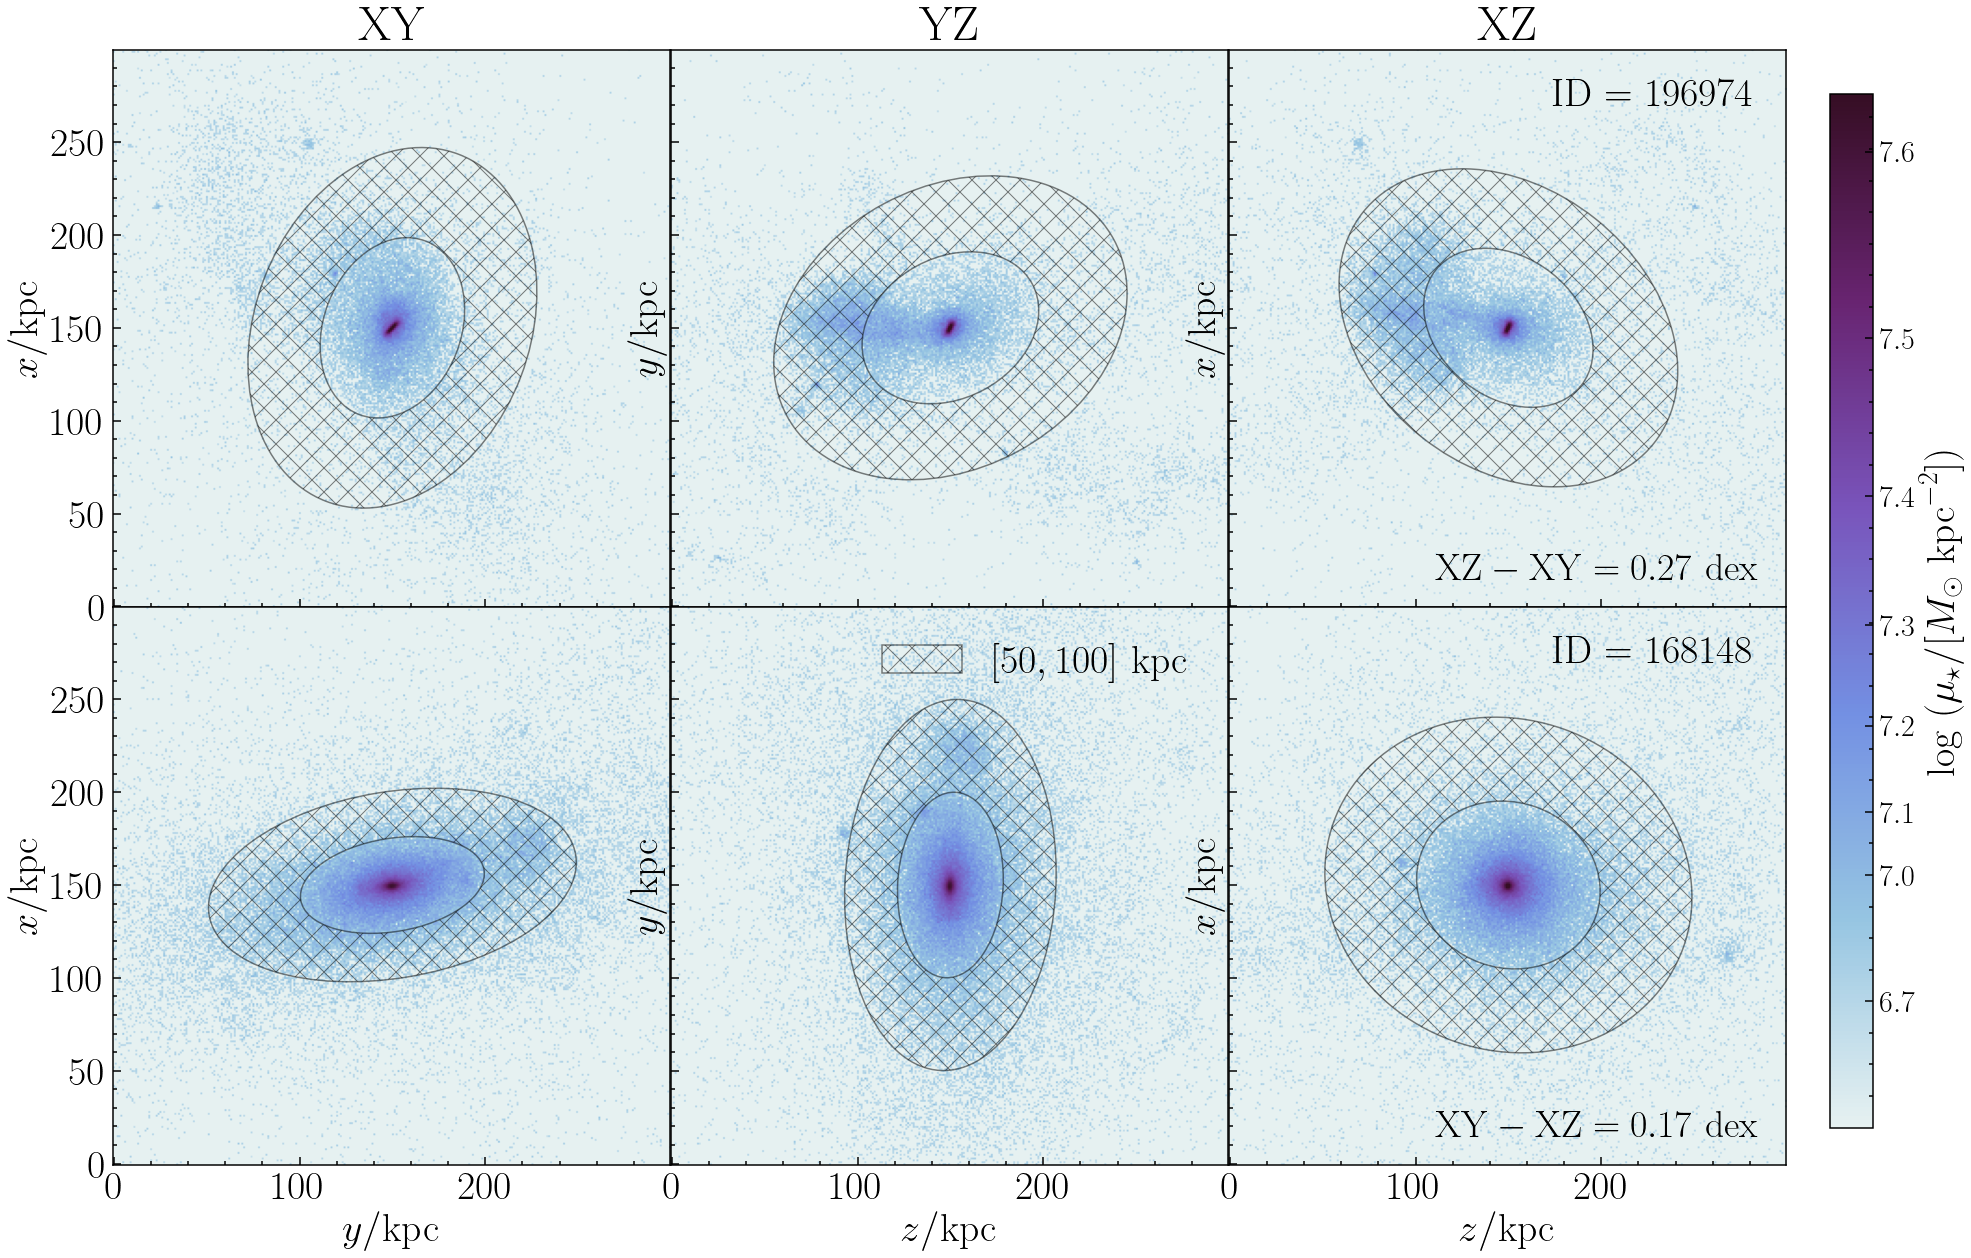

In [41]:
fig=plt.figure(figsize=(30,20.5))
gs = fig.add_gridspec(2,3, hspace=0, wspace=0,width_ratios=(1,1,1))
axlist= gs.subplots(sharex='col', sharey='row')
projlist=[r'\rm XY',r'\rm YZ',r'\rm XZ']
num_list=[r'$=196974$',r'$=168148$']
map_data0=map_dict1['map_data']
eps0=map_dict1['eps']
pa0=map_dict1['pa']
str_list=[r'${\rm XZ-XY}=0.27{\rm\ dex}$',r'${\rm XY-XZ}=0.17{\rm\ dex}$']
map_data=map_data0[1]
x_size, y_size = map_data.shape

map_max = map_data.max()
map_min = map_data[map_data > 0.0].min()   # none-zero min
min_value = 0.01
norm_factor0 = map_min / min_value
for i in range(3):
    map_data=map_data0[i]
    map_norm = map_data / norm_factor0
   
    ax1=axlist[0,i]
    eps=eps0[i]
    pa=pa0[i]
    SC=ax1.imshow(np.arcsinh(np.sqrt(map_norm*3)), origin='lower',cmap=cmap0,vmin=0,vmax=3.6)
    #ell=Ellipse((150,150),60,60*(1-eps),angle=pa,fill=False,ls='--',color='yellow',label=r'$30{\rm kpc}$')
    band=EllipticalAnnulus((150,150),a_in=50,a_out=100,b_in=50*(1-eps),b_out=100*(1-eps),theta=pa*np.pi/180)
    band1=band._to_patch(hatch='x',color='black',label=r'$[50,100]{\rm kpc}$',lw=1.5,alpha=0.5)
    ax1.add_patch(band1)
    #ax1.add_artist(ell)
    ax1.set_title(projlist[i])
map_data0=map_dict2['map_data']
eps0=map_dict2['eps']
pa0=map_dict2['pa']
map_data=map_data0[1]
x_size, y_size = map_data.shape


for i in range(3):
    map_data=map_data0[i]
    map_norm = map_data / norm_factor0
   
    ax1=axlist[1,i]
    eps=eps0[i]
    pa=pa0[i]
    ax1.imshow(np.arcsinh(np.sqrt(map_norm*3)), origin='lower',cmap=cmap0,vmin=0,vmax=3.6)
    #ell=Ellipse((150,150),60,60*(1-eps),angle=pa,fill=False,ls='--',color='yellow',label=r'$30{\rm kpc}$')
    band=EllipticalAnnulus((150,150),a_in=50,a_out=100,b_in=50*(1-eps),b_out=100*(1-eps),theta=pa*np.pi/180)
    band1=band._to_patch(hatch='x',color='black',label=r'$[50,100]${\rm\ kpc}',alpha=0.5,lw=1.5)
    ax1.add_patch(band1)
    #ax1.add_artist(ell)
    if i==0:
        ax1.set_xlabel(r'$y/{\rm kpc}$')
    else:
        ax1.set_xlabel(r'$z/{\rm kpc}$')
    
for i in range(2):
    ax1=axlist[i,0]
    ax1.set_ylabel(r'$x/{\rm kpc}$')
    ax1=axlist[i,1]
    ax1.set_ylabel(r'$y/{\rm kpc}$')
    ax2=axlist[i,2]
    ax2.text(0.58, 0.9, r'\rm ID '+num_list[i], transform=ax2.transAxes, size=40, color='Black')
    ax2.text(0.37, 0.05, str_list[i], transform=ax2.transAxes, size=38, color='Black')
    ax2.set_ylabel(r'$x/{\rm kpc}$')
    

# Colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(SC, cax=cax, orientation='vertical')
cbar.ax.set_yticks([0.44,0.88,1.1,1.4,1.75,2.2,2.75,3.4],list1,fontsize=30)
cbar.ax.set_ylabel(r'$\log\ (\mu_{\star}/[M_{\odot}\ \mathrm{kpc}^{-2}])$')
axlist[1,1].legend(labelcolor='Black',frameon=False)
plt.savefig(fig_dir+"Fig8.png",dpi=50)

In [37]:
list(np.round(np.log10(norm_factor0*np.sinh(np.asarray([0.44,0.88,1.1,1.4,1.75,2.2,2.75,3.4])/3**2))*100)/100)

[6.7, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6]

In [38]:
list1=[r'$6.7$', r'$7.0$', r'$7.1$', r'$7.2$',r'$7.3$', r'$7.4$', r'$7.5$', r'$7.6$']

In [46]:
np.asarray([1,1,1])-np.asarray(map_dict2['eps'])

array([0.50162435, 0.56775005, 0.89057777])